In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from prophet import Prophet
from prophet.plot import plot_plotly
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error
%matplotlib inline

In [2]:
# Assigning column names to the DataFrame
columns = ['Year', 'Month', 'Day', 'Fractional Year', 'Sunspot Number', 'Std Dev', 'Observations', 'Definitive']
daily_data = pd.read_csv("/Users/farhana/Downloads/Introduction to Data Science/Class Lectures/Projects/Project 3/SN_d_tot_V2.0.csv", sep=";", header=None, names=columns)
daily_data.head()

,Year,Month,Day,Fractional Year,Sunspot Number,Std Dev,Observations,Definitive
0,1818,1,1,1818.001,-1,-1.0,0,1
1,1818,1,2,1818.004,-1,-1.0,0,1
2,1818,1,3,1818.007,-1,-1.0,0,1
3,1818,1,4,1818.010,-1,-1.0,0,1
4,1818,1,5,1818.012,-1,-1.0,0,1


In [3]:
# Keeping only the necessary columns
daily_data = daily_data[['Year', 'Month','Day', 'Sunspot Number']]

daily_data.head()

,Year,Month,Day,Sunspot Number
0,1818,1,1,-1
1,1818,1,2,-1
2,1818,1,3,-1
3,1818,1,4,-1
4,1818,1,5,-1


In [4]:
daily_data['Sunspot Number'].replace(-1, np.nan, inplace=True)
daily_data['Date'] = pd.to_datetime(daily_data[['Year', 'Month', 'Day']])
daily_data.set_index('Date', inplace=True)
daily_data.drop(['Year', 'Month', 'Day'], axis=1, inplace=True)
daily_data.head(10)

,Sunspot Number
Date,
1818-01-01,NaN
1818-01-02,NaN
1818-01-03,NaN
1818-01-04,NaN
1818-01-05,NaN
1818-01-06,NaN
1818-01-07,NaN
1818-01-08,65.0
1818-01-09,NaN


In [5]:
print(daily_data.shape)

(74630, 1)


In [6]:
nan_rows = daily_data['Sunspot Number'].isna().sum()
print(f'Number of rows with NaN in Sunspot Number: {nan_rows}')

Number of rows with NaN in Sunspot Number: 3247


In [7]:
median_sunspot = daily_data['Sunspot Number'].median()
daily_data['Sunspot Number'].fillna(median_sunspot, inplace = True)

In [8]:
# Resetting the index to make 'Date' a column
daily_data = daily_data.reset_index()


In [9]:
daily_data = daily_data.rename(columns={'Date': 'ds', 'Sunspot Number': 'y'})


In [10]:
daily_data = daily_data[['ds', 'y']]


In [11]:
print(daily_data.head())
print(daily_data.info())


          ds     y
0 1818-01-01  62.0
1 1818-01-02  62.0
2 1818-01-03  62.0
3 1818-01-04  62.0
4 1818-01-05  62.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74630 entries, 0 to 74629
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      74630 non-null  datetime64[ns]
 1   y       74630 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.1 MB
None


# Sunspot Numbers Over Time 

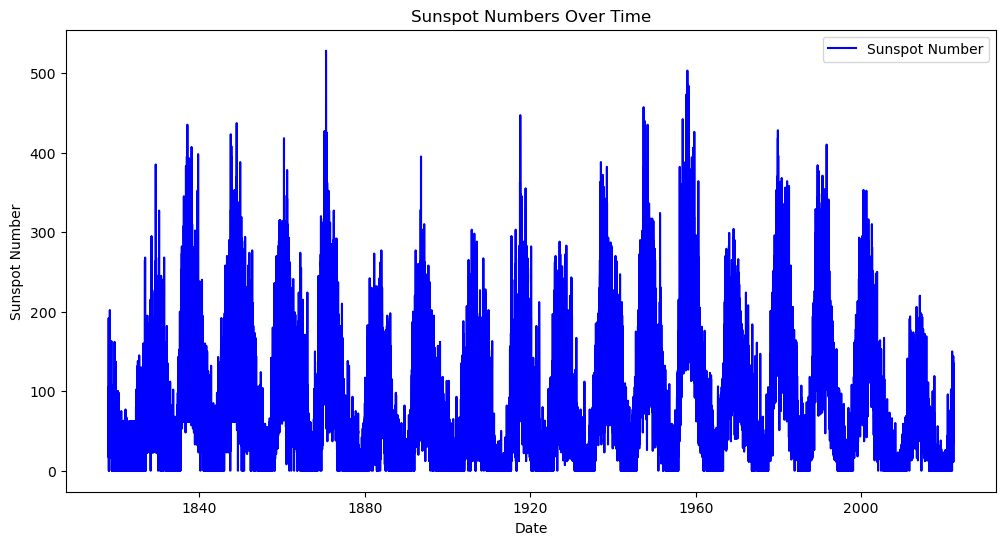

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(daily_data['ds'], daily_data['y'], label='Sunspot Number', color='blue')
plt.title('Sunspot Numbers Over Time')
plt.xlabel('Date')
plt.ylabel('Sunspot Number')
plt.legend()
plt.show()

# Average Sunspot Numbers by Month

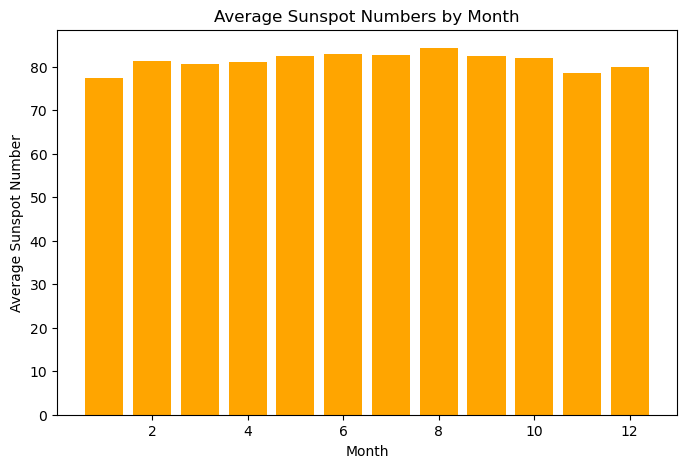

In [13]:
# Seasonality Analysis 
# Monthly aggregation
daily_data['month'] = daily_data['ds'].dt.month
monthly_avg = daily_data.groupby('month')['y'].mean()

plt.figure(figsize=(8, 5))
plt.bar(monthly_avg.index, monthly_avg.values, color='orange')
plt.title('Average Sunspot Numbers by Month')
plt.xlabel('Month')
plt.ylabel('Average Sunspot Number')
plt.show()

# Rolling Mean and Standard Deviation

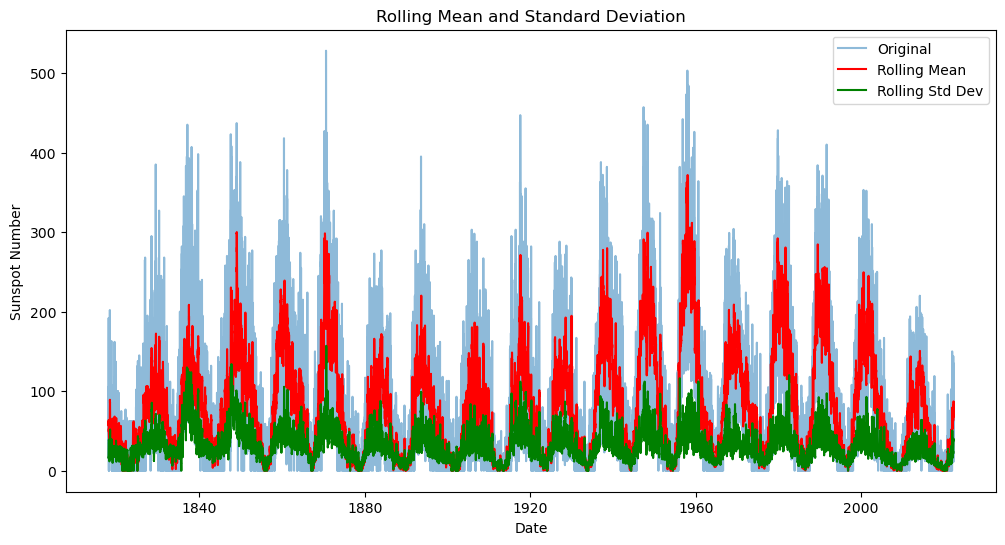

In [14]:
# Rolling Mean and Variance
daily_data['rolling_mean'] = daily_data['y'].rolling(window=30).mean()
daily_data['rolling_std'] = daily_data['y'].rolling(window=30).std()

plt.figure(figsize=(12, 6))
plt.plot(daily_data['ds'], daily_data['y'], label='Original', alpha=0.5)
plt.plot(daily_data['ds'], daily_data['rolling_mean'], label='Rolling Mean', color='red')
plt.plot(daily_data['ds'], daily_data['rolling_std'], label='Rolling Std Dev', color='green')
plt.title('Rolling Mean and Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Sunspot Number')
plt.legend()
plt.show()

# Distribution of Sunspot Numbers 

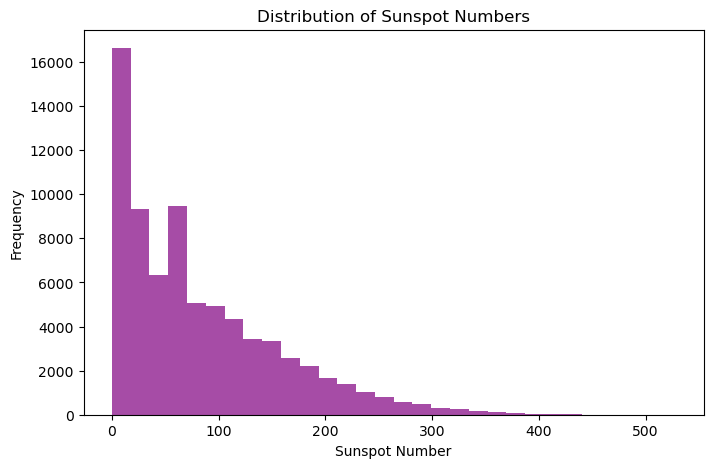

In [15]:
# Examining the distribution of sunspot numbers
daily_data['y'].plot(kind='hist', bins=30, color='purple', alpha=0.7, figsize=(8, 5))
plt.title('Distribution of Sunspot Numbers')
plt.xlabel('Sunspot Number')
plt.ylabel('Frequency')
plt.show()

In [16]:
# Selecting only the 'ds' and 'y' columns
daily_data = daily_data[['ds', 'y']]
print(daily_data.head())

          ds     y
0 1818-01-01  62.0
1 1818-01-02  62.0
2 1818-01-03  62.0
3 1818-01-04  62.0
4 1818-01-05  62.0


In [17]:
# Train-Test Split (80-20)
train_size = int(0.8 * len(daily_data)) 
train = daily_data[:train_size]
test = daily_data[train_size:]

print(f"Train dataset date range: Start: {train['ds'].min()} End: {train['ds'].max()}")
print(f"Test dataset date range: Start: {test['ds'].min()} End: {test['ds'].max()}")

Train dataset date range: Start: 1818-01-01 00:00:00 End: 1981-06-18 00:00:00
Test dataset date range: Start: 1981-06-19 00:00:00 End: 2022-04-30 00:00:00


In [18]:
print(f"Training Set Size: {len(train)}")
print(f"Testing Set Size: {len(test)}")

Training Set Size: 59704
Testing Set Size: 14926


# Model Training

In [19]:
# Defining the model with necessary parameters
def create_prophet_model():
    model = Prophet(
        growth='logistic',  
        changepoint_prior_scale=0.5, 
        seasonality_mode='multiplicative' 
    )
    
    model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    model.add_seasonality(name='yearly', period=365.25, fourier_order=10)
    return model

model = create_prophet_model()

max_y = train['y'].max() * 1.1  
train['cap'] = max_y
model.fit(train)

/var/folders/zq/25twj4z91c95fby10kwlwmw80000gn/T/ipykernel_41738/1803333304.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['cap'] = max_y
20:50:42 - cmdstanpy - INFO - Chain [1] start processing
20:51:56 - cmdstanpy - INFO - Chain [1] done processing


# Forecasting

In [20]:
# Creating the future dataframe based on the test data 
df_future = model.make_future_dataframe(periods=len(test), freq='D')

# Adding cap and floor for logistic growth 
df_future['cap'] = 0.95 * train['y'].max()  
df_future['floor'] = 1.05 * train['y'].min()  

forecast = model.predict(df_future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round().tail()

,ds,yhat,yhat_lower,yhat_upper
74625,2022-04-26,52.0,-217.0,377.0
74626,2022-04-27,53.0,-219.0,374.0
74627,2022-04-28,54.0,-218.0,389.0
74628,2022-04-29,54.0,-220.0,377.0
74629,2022-04-30,54.0,-211.0,382.0


# Model Evaluation

In [21]:
# Merging the forecast with the test data
results = forecast[['ds', 'yhat']].merge(test, on='ds', how='inner')

# Calculating metrics
mae = mean_absolute_error(results['y'], results['yhat'])
mse = mean_squared_error(results['y'], results['yhat'])
rmse = np.sqrt(mse)

print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}")

MAE: 56.73, MSE: 5226.04, RMSE: 72.29


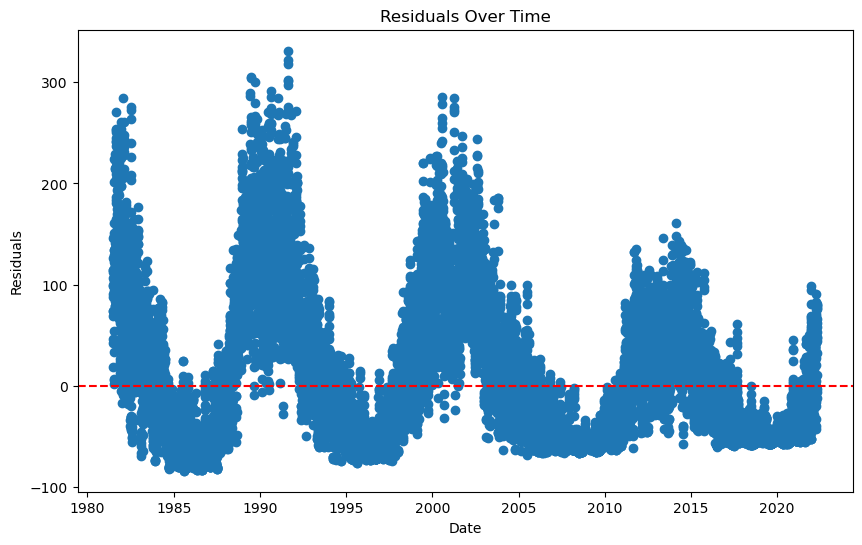

In [22]:
results['residuals'] = results['y'] - results['yhat']

# Plotting residuals
plt.figure(figsize=(10, 6))
plt.plot(results['ds'], results['residuals'], marker='o', linestyle='none')
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residuals Over Time")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.show()

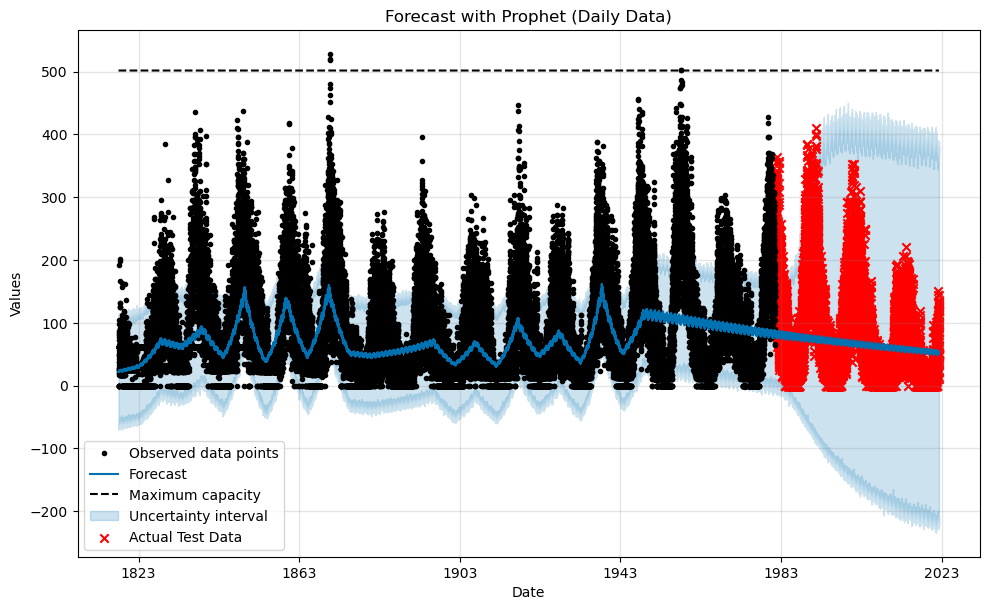

In [23]:
# Plotting the forecast from Prophet
fig = model.plot(forecast)
plt.title('Forecast with Prophet (Daily Data)')

plt.scatter(
    test['ds'],  
    test['y'],  
    color='red',     
    label='Actual Test Data', 
    marker='x'        
)

plt.legend()
plt.xlabel("Date")
plt.ylabel("Values")
plt.show()